In [3]:
%matplotlib inline
%load_ext rpy2.ipython
import xarray as xr
import pandas as pd
import numpy as np
import os
import glob
import netCDF4
import matplotlib.pyplot as plt
import warnings
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import STAP
from rpy2.rinterface_lib.embedded import RRuntimeError

warnings.simplefilter("ignore")
plt.style.use("ggplot")
numpy2ri.activate()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Tercile plots for GOTM output

This notebook compares results from GOTM using the **ERA5** data as "pseudo-observations" against predictions made using **S5** forecasts for each season in each year (with a 13 month warm-up period). It is based on the notebook *gotm_era_interim_s4_terciles.ipynb* that did essentailly the same using ERA-Interim and S4.

The aim is to create tercile plots for each season in each year for three variables: temperature, ice thickness and surface mixed layer depth.

## 1. User input

In [4]:
# Define seasons
seasons_dict = {
    "winter": [12, 1, 2],
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "autumn": [9, 10, 11],
}

# Years of interest
st_yr = 1994
end_yr = 2016

# Number of members in modelled data
members = 25

# Paths to datasets
store_obs_nc_path = (
    r"/home/jovyan/shared/WATExR/ERA5/Vansjo_simplyQ_gotm/store_full_era5.nc"
)
vanem_obs_nc_path = (
    r"/home/jovyan/shared/WATExR/ERA5/Vansjo_simplyQ_gotm/vanem_full_era5.nc"
)

store_mod_fold = r"/home/jovyan/shared/WATExR/ERA5/Vansjo_simplyQ_gotm/store"
vanem_mod_fold = r"/home/jovyan/shared/WATExR/ERA5/Vansjo_simplyQ_gotm/vanem"

# Folder in which to save tercile PDFs
terc_fold = r"./era5_s5_terc_plots/no_temp_corr"

# Path dict with values as (obs, mod)
path_dict = {
    "store": (store_obs_nc_path, store_mod_fold),
    "vanem": (vanem_obs_nc_path, vanem_mod_fold),
}

# Correct temperature data by subtracting monthly means
corr_temp = False

## 2. Utility functions

In [5]:
def gotm_vars_to_dataframe(ds, basin):
    """ Processes/aggregates the different variables of interest and returns a dataframe
        with one column per variable.
        
    Args:
        ds:    Xarray dataset of GOTM output
        basin: Str. 'store' or 'vanem'
        
    Returns:
        Dataframe
    """
    from netCDF4 import Dataset

    # xarray can't read real depths from GOTM output
    # https://github.com/pydata/xarray/issues/2368#issuecomment-443218629
    # patch using netcdf4
    ds_path = (
        f"/home/jovyan/shared/WATExR/ERA5/Vansjo_simplyQ_gotm/{basin}_full_era5.nc"
    )
    ds2 = Dataset(ds_path, "r", format="NETCDF4")
    ds["z"] = ds2["z"][0, :, 0, 0]

    if basin == "vanem":
        # Extracts temperatures for depths of interest
        df = (
            ds["temp"].sel(z=[0, -6, -15], method="nearest").to_dataframe().unstack("z")
        )
        df.index = df.index.get_level_values("time")
        df.columns = ["0m", "6m", "15m"]

    elif basin == "store":
        # Get streamflow
        # 'int_water_balance' is water volume accumulated through the entire run.
        # To get flow, take first difference w.r.t. 'time' axis, then divide by 24*60*60
        ds["streamflow"] = ds["int_water_balance"].diff("time") / (24 * 60 * 60)

        # Use means (overall depths where relevant) for now
        df = ds[["streamflow"]].mean(dim=["lat", "lon"]).to_dataframe()

    else:
        raise ValueError("Basin not recognised.")

    df.index = pd.to_datetime(df.index.date)

    return df

def subtract_monthly_means(ser, variable):
    """ Calculates monthly means for the supplied series, then computes the 
        difference in means between the first month in each season of the 
        aggregated series and subsequent months. These differences are subtracted 
        from the daily values to correct for within-season changes. 
        
        Each season comprises three months, indexed 0, 1 and 2. For any daily time
        series t_ymd, the series of monthly means, tbar_ym is calculated. For each 
        year and month in the monthly series, the differences from months 0 to 1 
        and 0 to 3 are calculated:
        
            tdiff_ym1 = tbar_ym1 - tbar_ym0
            tdiff_ym2 = tbar_ym2 - tbar_ym0
            
        All daily values for each year and month for months 1 and 2 are then 
        corrected:
        
            t_ym1d = t_ym1d - tdiff_ym1
            t_ym2d = t_ym2d - tdiff_ym2
            
        Args:
            ser:      Series of raw data with datetime index and daily frequency
            variable: Str. Name of data series
            
        Returns:
            Series. Data in the same format as the input, but with values corrected 
            as described above.
    """
    # ERA5 
    # Convert to monthly
    ser_mon = pd.DataFrame(ser.resample('M').mean())
    ser_mon['month'] = ser_mon.index.month
    ser_mon['year'] = ser_mon.index.year
    
    # Differences between months relative to first month
    ser_mon['diff'] = ser_mon[variable].diff()
    ser_mon['diff'].fillna(0, inplace=True)
    ser_mon['diff'] = ser_mon['diff'] + ser_mon['diff'].shift(1)
    ser_mon['diff'].fillna(0, inplace=True)
    
    # Join to daily
    ser = pd.DataFrame(ser)
    ser['month'] = ser.index.month
    ser['year'] = ser.index.year
    ser['date'] = ser.index
    ser = pd.merge(ser, ser_mon[['month', 'year', 'diff']], on=['month', 'year'], how='left')
    ser.set_index('date', inplace=True)
    
    # Apply correction
    ser[variable] = ser[variable] - ser['diff']
    
    # Get series
    ser = ser[variable]
    
    return ser
    
def corr_seaonal_obs_mod(obs, mod, variable):
    """ Applies corrections based on monthly means to ERA5 (obs) and S5 (mod) datasets.
    
    Args:
        mod:      Dataframe of S5 data with datetime index and daily frequency
        obs:      Series of ERA5 data with datetime index and daily frequency
        variable: Str. Name of data series
        
    Returns:
        Tuple (obs, mod). Data in the same format as the input, but with values corrected 
            as described above.    
    """
    obs = obs.copy()
    mod = mod.copy()
    
    # Correct ERA5
    obs = subtract_monthly_means(obs, variable)
    
    # Correct s5
    for col in mod.columns:
        mod[col] = subtract_monthly_means(mod[col], col)
        
    return (obs, mod)

As far as possible, I'd like to use the `visualizeR` functions for generating the pots, in order to be consistent with other work. I'll do most of the data processing in Python, then pass variables over to R and re-structure for the crucial last steps in each loop.

In [6]:
r_fct = """    
tercile_plot <- function(var_name, long_name, st_dates, end_dates, obs_values, mod_values, out_path, mod_template){

    # Function to reformat GOTM data for use in visualizeR's tercilePlot and FairRPSS functions.
    # Uses an example of the 'obs' and 'mod' output for a single variable saved
    # from the notebook here:
    #
    #     WATExR/Norway_Morsa/MetData_Processing/notebooks/03_validation_tercile_plots.ipynb
    #
    # Args:
    #     var_name:     Str. Short name for variable
    #     long_name:    Str. Long name for variable
    #     st_dates:     Numpy array of strings with dates in format 'YYYY-MM-DD'
    #     end_dates:    Numpy array of strings with dates in format 'YYYY-MM-DD'
    #     obs_values:   Numpy array of floats
    #     mod_values:   Numpy array of floats
    #     out_path:     Str. Path to PDF to be created
    #     mod_template: Str. Either 'mod_data_template_15_members.rda' or 'mod_data_template_25_members.rda',
    #                   depending on how many members you're using in 'mod_values'
    # 
    # Returns:
    #     Float vector c(FairRPSS, significance). Tercile plot PDF is saved to the path specified.

    suppressPackageStartupMessages(library(Cairo))
    suppressPackageStartupMessages(library(visualizeR))
    suppressPackageStartupMessages(library(easyVerification))
    
    # Convert dates to vectors with POSIX format
    st_dates <- c(st_dates)
    st_dates <- strptime(st_dates, "%Y-%m-%d")
    end_dates <- c(end_dates)
    end_dates <- strptime(end_dates, "%Y-%m-%d")

    # Obs values as R array
    obs_values <- array(obs_values)
    attr(obs_values, "dimensions") <- c("time")

    # Mod values as R array
    mod_values <- array(mod_values, dim = c(25, length(st_dates)))
    attr(mod_values, "dimensions") <- c("member", "time")

    # Load data "templates" from original tercile plot script
    obs_temp <- get(load("obs_data_template.rda"))
    mod_temp <- get(load(mod_template))

    # Update obs "template" with new data
    obs_temp$Variable$varName <- var_name
    attr(obs_temp$Variable, 'longname') <- long_name
    obs_temp$Data <- obs_values
    obs_temp$Dates$start <- st_dates
    obs_temp$Dates$end <- end_dates

    # Update mod "template" with new data
    mod_temp$Variable$varName <- var_name
    attr(mod_temp$Variable, 'longname') <- long_name
    mod_temp$Data <- mod_values
    mod_temp$Dates$start <- st_dates
    mod_temp$Dates$end <- end_dates
    mod_temp$InitializationDates <- NULL

    # Make tercile plot
    CairoPDF(file = out_path, width = 10)
    tercilePlot(obs = redim(obs_temp), hindcast = redim(mod_temp))
    dev.off()
    
    # Calculate FairRPSS
    frpss <- veriApply(verifun = "FairRpss",
                       fcst = mod_temp$Data,
                       obs = obs_temp$Data,
                       prob = c(1/3,2/3),
                       tdim = 2, 
                       ensdim = 1)
                       
    return (c(frpss$skillscore, frpss$skillscore.sd))
}
"""

# Load R function for making tercile plots
r_pkg = STAP(r_fct, "r_pkg")

## 3. Data processing

In [7]:
basin_list = []
season_list = []
variable_list = []
frpss_list = []
sig_list = []

# Loop over basins
for basin in path_dict.keys():
    print(f"Processing: {basin}fjorden")
    obs_path = path_dict[basin][0]
    mod_fold = path_dict[basin][1]

    # Read obs
    obs_ds = xr.open_dataset(obs_path, drop_variables="z")
    obs_df = gotm_vars_to_dataframe(obs_ds, basin)

    # Loop over seasons
    for season in seasons_dict.keys():
        print(f"  {season}")
        print(f"    Getting S5 data")

        mem_list = []

        # Loop over S5 members
        for mem in range(1, 26):
            # Get S5 data for member (for all years in this season)
            search_path = os.path.join(mod_fold, f"{basin}_*_{season}_{mem}.nc")
            flist = sorted(glob.glob(search_path))

            # Loop over files for each year
            year_list = []
            for fpath in flist:
                mem_yr_ds = xr.open_dataset(fpath, drop_variables="z")
                mem_yr_df = gotm_vars_to_dataframe(mem_yr_ds, basin)

                # Get just the months of interest
                months = seasons_dict[season]
                mem_yr_df = mem_yr_df.iloc[
                    -100:
                ]  # Ensures we don't gets months from the previous year "warm-up" too
                mem_yr_df["month"] = mem_yr_df.index.month
                mem_yr_df = mem_yr_df.query("month in @months")
                del mem_yr_df["month"]

                year_list.append(mem_yr_df)

            # Build single df for this member for all years
            mem_df = pd.concat(year_list, axis="rows")

            # Create multi-index with member
            iterables = [mem_df.columns, [mem + 1,]]
            mem_df.columns = pd.MultiIndex.from_product(
                iterables, names=["variable", "member"]
            )
            mem_list.append(mem_df)

        # Build a dataframe of all members
        mod_df = pd.concat(mem_list, axis="columns")

        # Subset to 1994 - 2016
        mod_df = mod_df[(mod_df.index.year >= st_yr) & (mod_df.index.year <= end_yr)]

        # Get matching dates from obs df
        obs_df_seas = obs_df[obs_df.index.isin(mod_df.index)]

        assert len(obs_df_seas) == len(
            mod_df
        ), f"Dataframe lengths do not match for {season}."

        # Loop over variables
        if basin == "store":
            variables = ["streamflow"]
        else:
            variables = ["0m", "6m", "15m"]

        for variable in variables:
            # Get data series
            obs = obs_df_seas[variable]
            mod = mod_df[variable]
            
            if corr_temp:
                if variable != 'streamflow':
                    # Subtract means
                    obs, mod = corr_seaonal_obs_mod(obs, mod, variable)                    

            try:
                # Extract components for passing to R
                if variable == "streamflow":
                    long_name = "Daily average streamflow"
                else:
                    long_name = obs_ds["temp"].attrs["long_name"] + f" ({variable})"
                st_dates = obs.index.strftime("%Y-%m-%d").values
                end_dates = (
                    (obs.index + pd.DateOffset(days=1)).strftime("%Y-%m-%d").values
                )  # Shifted by 1 day from 'start'
                obs_values = obs.values
                mod_values = mod.values.T
                out_pdf = os.path.join(
                    terc_fold, f"gotm_era5_s5_terc_plot_{basin}_{variable}_{season}.pdf"
                )
                mod_template = f"mod_data_template_{members}_members.rda"

                # Make plot using R function
                frpss, sig = r_pkg.tercile_plot(
                    variable,
                    long_name,
                    st_dates,
                    end_dates,
                    obs_values,
                    mod_values,
                    out_pdf,
                    mod_template,
                )

                # Store FRPSS
                basin_list.append(basin)
                season_list.append(season)
                variable_list.append(variable)
                frpss_list.append(frpss)
                sig_list.append(sig)

                print(f"      Finished plot for: {variable}")

            except RRuntimeError:
                print(f"      Skipping {variable} as insufficient data.")

# Save FRPSS results
frpss_df = pd.DataFrame(
    {
        "basin": basin_list,
        "season": season_list,
        "varaible": variable_list,
        "frpss": frpss_list,
        "sig": sig_list,
    }
)
#csv_path = r"./era5_s5_terc_plots/morsa_gotm_frpss.csv"
#frpss_df.to_csv(csv_path, index=False)

Processing: storefjorden
  winter
    Getting S5 data

    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=20s  
      Finished plot for: streamflow
  spring
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=16s  
      Finished plot for: streamflow
  summer
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  
      Finished plot for: streamflow
  autumn
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  
      Finished plot for: streamflow
Processing: vanemfjorden
  winter
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=17s  
      Finished plot for: 0m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=16s  
      Finished plot for: 6m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=16s  
      Finished plot for: 15m
  spring
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=19s  
      Finished plot for: 0m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=17s  
      Finished plot for: 6m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=17s  
      Finished plot for: 15m
  summer
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  
      Finished plot for: 0m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=18s  
      Finished plot for: 6m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=17s  
      Finished plot for: 15m
  autumn
    Getting S5 data


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=21s  
      Finished plot for: 0m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=23s  
      Finished plot for: 6m


R[write to console]: Please note that FairRpss is computed without ensemble-size correction for the climatological reference forecast, as categories are based on quantiles of the observations and forecast probabilities are therefore known.



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=23s  
      Finished plot for: 15m


## 4. Checking

The code below generates a tercile plot using Python, based on my understanding of what the `visualizeR` function is doing. Note that the code below **doesn't make allowances for winter months crossing the year-end boundary**, so it is not expected to produce correct results for winter. However, comparisons for the other seasons seem OK and are enough to convince me that my Python <-> R interaction are working reasonably.

In [8]:
print(basin, variable, season)

vanem 15m autumn


In [9]:
obs_ann = obs.groupby(obs.index.year).mean()
obs_quants = obs_ann.quantile([0.33, 0.67])
obs_quants

0.33    8.301842
0.67    9.362069
Name: 15m, dtype: float64

In [10]:
# Build bins for terciles
terc_bins = obs_quants.values
terc_bins = np.insert(terc_bins, 0, -np.inf)
terc_bins = np.append(terc_bins, np.inf)
terc_bins

array([      -inf, 8.30184196, 9.36206936,        inf])

In [11]:
mod_ann = mod.groupby(mod.index.year).mean()
mod_ann.head()

member,2,3,4,5,6,7,8,9,10,11,...,17,18,19,20,21,22,23,24,25,26
1994,10.223046,7.879027,10.572659,9.433191,9.909911,8.527033,9.545766,8.468828,7.408168,9.044772,...,8.684038,7.675096,9.662690,8.421983,8.409681,8.077527,7.740269,9.041493,10.577020,7.879797
1995,9.839882,8.683654,8.468458,8.316753,8.931182,9.037744,8.155168,8.110666,7.891708,8.059097,...,8.240545,7.951240,9.023042,8.608373,8.739909,9.074190,9.474339,9.165842,9.093004,7.438848
1996,7.820845,8.476952,7.746147,7.758765,8.239823,7.971889,8.467787,7.406255,6.180156,10.250924,...,9.645031,9.163527,7.606128,9.039488,9.783710,7.657372,8.801881,7.311495,7.343064,8.763574
1997,7.540645,9.544162,10.152569,9.865912,10.416959,8.599221,8.521222,10.042872,8.248720,6.751877,...,8.348022,9.602553,9.292320,8.481312,9.609064,9.937718,7.604776,8.480041,8.580969,9.944686
1998,10.681649,10.115536,8.727188,9.374203,8.798390,9.366485,10.325024,9.423407,8.300220,8.607430,...,9.091231,8.969801,8.856601,7.965146,8.899528,8.873831,8.713664,9.620989,8.728640,8.440093


In [12]:
# Get terciles
df_list = []
for year in mod_ann.index:
    terc_df = pd.cut(
        mod_ann.loc[year],
        bins=terc_bins,
        labels=["Below normal", "Near normal", "Above normal"],
    )

    terc_prob = 100 * terc_df.value_counts() / 25
    df_list.append(terc_prob)

df = pd.concat(df_list, axis="columns").T

df.head()

,Below normal,Near normal,Above normal
1994,28.0,28.0,44.0
1995,28.0,56.0,16.0
1996,52.0,32.0,16.0
1997,16.0,40.0,44.0
1998,16.0,56.0,28.0


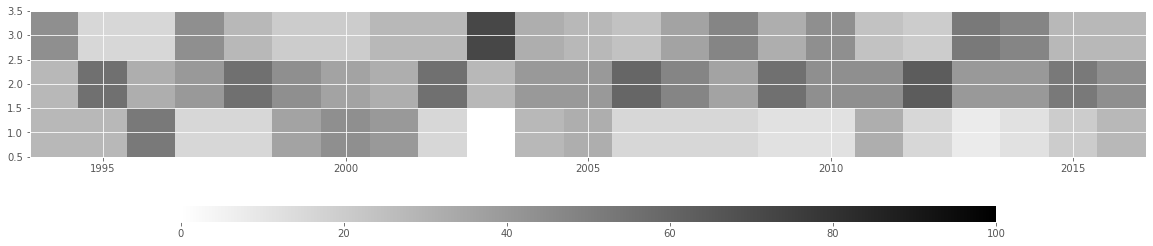

In [13]:
data = df.T.iloc[::-1].values
fig = plt.figure(figsize=(20, 6))
plt.imshow(
    data, cmap="gray_r", extent=[st_yr - 0.5, end_yr + 0.5, 0.5, 3.5], vmin=0, vmax=100
)
plt.colorbar(orientation="horizontal", fraction=0.05, aspect=50)

##  Appendix

The following "interactive" code was used to develop and test the R `tercile_plot` function.

In [14]:
# # Get data for testing
# obs = obs_df_seas["0m"]
# mod = mod_df["0m"]

# # Extract components for passing to R
# var_name = '0m'
# long_name = 'Temperature'
# st_dates = obs.index.strftime('%Y-%m-%d').values
# end_dates = (obs.index + pd.DateOffset(days=1)).strftime('%Y-%m-%d').values
# obs_values = obs.values
# mod_values = mod.values.T

In [15]:
# %%R -i var_name,long_name,st_dates,end_dates,obs_values,mod_values -o mod_temp,obs_temp

# suppressPackageStartupMessages(library(Cairo))
# suppressPackageStartupMessages(library(visualizeR))

# st_dates <- c(st_dates)
# st_dates <- strptime(st_dates, "%Y-%m-%d")
# end_dates <- c(end_dates)
# end_dates <- strptime(end_dates, "%Y-%m-%d")

# obs_values <- array(obs_values)
# attr(obs_values, "dimensions") <- c("time")

# mod_values <- array(mod_values, dim = c(25, length(st_dates)))
# attr(mod_values, "dimensions") <- c("member", "time")

# obs_temp <- get(load("obs_data_template.rda"))
# mod_temp <- get(load("mod_data_template_25_members.rda"))

# obs_temp$Variable$varName <- var_name
# attr(obs_temp$Variable, 'longname') <- long_name
# obs_temp$Data <- obs_values
# obs_temp$Dates$start <- st_dates
# obs_temp$Dates$end <- end_dates

# mod_temp$Variable$varName <- var_name
# attr(mod_temp$Variable, 'longname') <- long_name
# mod_temp$Data <- mod_values
# mod_temp$Dates$start <- st_dates
# mod_temp$Dates$end <- end_dates
# mod_temp$InitializationDates <- NULL

# CairoPDF(file = 'test', width = 10)
# tercilePlot(obs = redim(obs_temp), hindcast = redim(mod_temp))